### The following is from [HERE](https://geographicdata.science/book/notebooks/09_spatial_inequality.html), then modified as the example is worked through

## Spatial Inequality Dynamics

This notebook we will use economic inequality to illustrate how the study of the evolution of social disparities can benefit from and explicitly spatial treatment. Social and economic inequality is often at the top of policymakers' agendas. Its study has alwasy drawn considerable attention in acedemic circles. Much of the focus has been on *interpersonal income inequality*, on differences between individuals irrespective of the geographical area in which they live. Yet there is a growing recognition that the question of *inter-regional income inequalities* requires further attention as the growing gaps between poor and rich regions have been identified as key drivers of civil unrest [Ezc19](https://doi.org/10.1080/10242694.2018.1446621) and political polorization in developing andd developed countries [RP18](https://doi.org/10.1093/cjres/rsx024).


### Introduction

Mucch of the study of inequalities has focused at the individual level: *how do oucomes differ accross individuals?* This approach does not group individuals geographically. In other words, it is not concerned with thether those differences follow a pattern, for example, at the regional level (e.g., *is most of the more disadvantaged population located in a particular section of the map?*). Indeed, whereas the two literatures (personal and regional inequality) are indeed related, they have developed in a largley parellel fashion with limited cross-fertilization. In this notebook, we examine how a spatially explicit focus can provide insights on the study of inequalities and its dynamics. We hope this illustration can be useful in itself but also inspire the use of these methods in the study of other phenomena for which the regional perspective can bring value. This is also the only chapter where we explicitly deal with time as an additional dimension. Our presentation of inequalities takes an inherently temporal view, considering how different indices evolve over time the extent to which a spatial pattern changes. Again, we hope the illustration we show here with inequality indices has value in itself, but also as inspiration for how to tackle time and dynamics in broader contexts.

After discussing the data we aim to employ, we begin with an introdiction to classic methods for interpersonal incom inequality analysis and how they have been adopted to the question of regional inequalities. These included a number of graphical toole alongsided familiar indicies of inequality. As we discuss more fully, the use of these classical methods in spatially referenced data, while useful in providing insights on some aspects of spatial inequality, fails to fully capture the nature of geographical disparities and their dynamics. Thus, we next move to the spatially explicit measures for regional inequality analysis. 

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import geopandas as gpd
import pysal
import mapclassify
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


### Date: U.S. State per capita Income, 1969-2017

For this notebook, we use data on average income per capita over time. Specifically, we consider the United States counties from 1969 to 2017. The U.S. counties are small regions that fit hierarchically within states. This perspective will allow us to examine trends for individual observations (counties), or regions containing several of them in a geographically consistent way (states or census regions which are collections of states). The temporal approach will reveal whether these entities get richer or poorer, as well as how the overall distribution of income moves, skews, or spreads out.

In [2]:
pci_df = gpd.read_file(
                    "../data/us_county_income/uscountypcincome.gpkg"
                    )
pci_df['GeoFIPS'].head()#.describe()

0    55111
1    55093
2    55063
3    55033
4    55053
Name: GeoFIPS, dtype: object

Inspection of the column names reveals that the table is organized around one row per county and with the years as columns, together with the information about the particular record. This format is an example of a *wide* longitudinal dataset, in  uniqurwide-format, each column represents a set of measurments made about the sam "entity" over time (as well as any unique identifying information about the entity). This contrasts with a *narrow, long* format, where each row describes an entity at a specific point in time. Long data results in significant duplication for records and is generally worse for data storage, particuarly in the geographic case. However, long-format data is sometimes a more useful format ahen manipulating and analyzing data, as [W+14](https://geographicdata.science/book/notebooks/references.html#id89) discusses. Nonethless, when analyzing *trajectories*, that is the paths that entities take over time, wide data is more useful, and we will use that here. 

In this dataset, we have 3076 counties across 49 years, as well as 28 extra columns that describe each county. 

In [3]:
pci_df.shape

(3076, 77)

In [4]:
# Convert years columns to numeric, coercing errors to NaNs
pci_df.loc[:,"1969":"1979"] = pci_df.loc[:,"1969":"1979"]\
            .apply(pd.to_numeric, errors='coerce')

As an example, we can see the first ten years for Jackson County, Misssissippi (state code 28) below:

In [5]:
pci_df.query('NAME == "Jackson" & STATEFP =="28"').loc[:,"1969":"1979"]

,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979
1417,2957,3121,3327,3939,4203,4547,5461,5927,6315,6619,6967


### Global Inequality

We begin our examination of inequality by focusing on several global measures of incom inequality. Here, "global" means that the measure is concerned with the overall nature of inequalitywithin the income distribution. That is, these measures focus on the direct disparity between rich and poot, considering nothing about where the rich and poor live, Several classic measures of inequality are avalible for this purpose. 

In general terms, measures of inequality focus on the dispersion present in an income distribution. In the case of regional or spatial inequality, the distributions describe the average of per capita incomes for spatial units, such as for counties, census tracts, or regions. For our U.S. county level data, we can visulize the distribution of per capita incomes for the first year in the sample as follows:

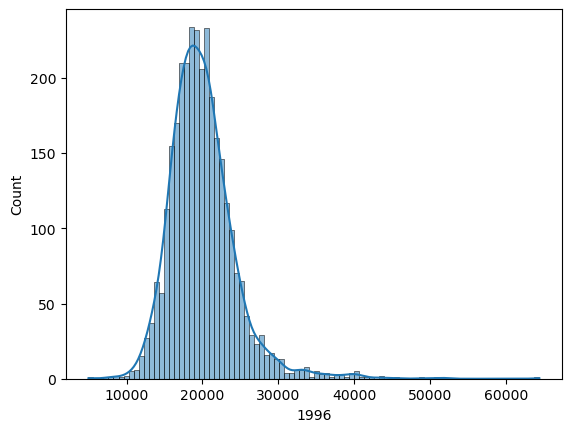

In [6]:
sns.histplot(x=pci_df["1996"], kde=True);

Looking ath this distribution, notice the right side of the distribution is much longer thatn the left side. This long right tail - a predominate feature-is common in the study of incomes and many other societal phenomena, as it illistrates the fact: that witihin a single income distribution, the super-rich are generally much more wealthy than the super-poor are deprived compared to the average (as far as income is concerned individuals are bound on the lower end by 0 income, there is no simmilar bound on the top end, creating this skewed distribution).

A key point to keep in mind here it that the unit of measurment in these data is the spatial aggregate of individual incomes, (here we are using the per capita incomes for each county). By contrast, in the wider incom inequality literature, the observational units are typically a household or individual. In the latter distributions, the degree of skeyness is oftem more pronounced. This difference arises from the smoothing that is intrinsic to aggregation: ther regional distributions are based on averages obtained from those individual distributions, so the extremly high-income individuals are averaged with the rest of their county. The regional approach implies that, to avoid falling into the so-called "ecological falacy", whereby individual conclusions are drawn from geographical aggregates, our conclusions will hold at the area level (in this case county) rather than at the indiviual (person) level.

As an aside, if we take the natural log of income, this resolve the skew on the distribution should we need to perfom a statistical test that assumes a normal distrobution:

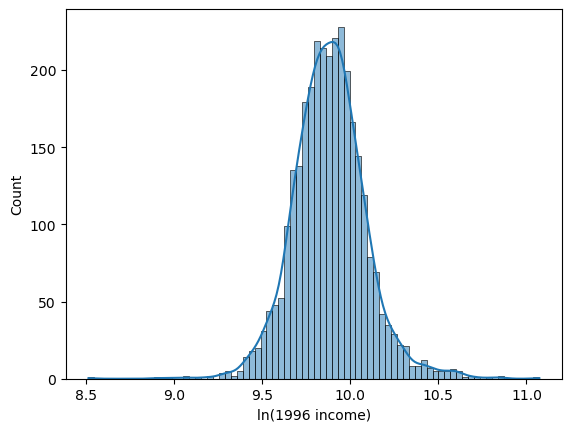

In [7]:
ax = sns.histplot(x=pci_df["1996"].apply(lambda x: np.log(x)), kde=True);
ax.set(xlabel="ln(1996 income)");

The kernel density estimate (or histogram) is a powerful visualization device that captures the overall morphology of the feature distribution for this measure of income. At the same time, the plot is silent on the underlying geographic distribution of county incomes. We can look at this second view of the distribution using a choropleth map. To construct this, we can use the standard geopandas plotting tools.

Before we can get to mapping, we change the CRS to a suitable one for mapping, the Albers Equal Area projection for North America:


In [8]:
pci_df = pci_df.to_crs(epsg=5070) #albert equal area projection for North America

... and now we can plot the choropleth map with the included geometry field

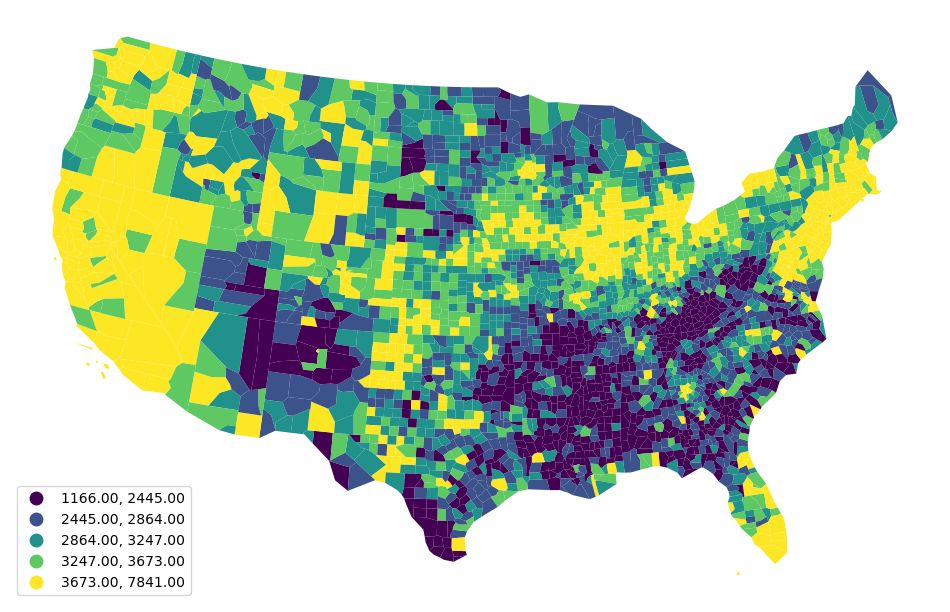

In [9]:
ax = pci_df.plot(
                 column="1969",
                 scheme="Quantiles",
                 legend=True,
                 edgecolor="none",
                 legend_kwds={"loc":"lower left"},
                 figsize=(12,12),
                )
ax.set_axis_off()
plt.show()

The choropleth and the kernel density provide different visual dpictions of the distribution of county incomes. The Kernal density estimate is a *feature* based representation, and the map is a *geographic*-based representation. Both are useful for developing a more comprehensive understanding. To gain insights on the level of inequality in the distributions, we'll discuss a few indicies common in the staatistical and ecomomentric literatures. 


#### 20:20 Ratio

One commonly used measure of inequality in a distribution in the so-called 20:20 ratio, which in defined as the ration of the incomes at the 80th percentile over those at the 20th percentile. 

In [10]:
top20, bottom20 = pci_df["1969"].quantile([0.8, 0.2])

In [11]:
top20 / bottom20

1.5022494887525562

in 1969 the richest 20% of the counties had an income that was ~1.5 times the poorest 20% of the counties. The 20:20 ratio has the advantage of being robust to outliers at the top and bottom of the distribution. To look at the dynamics of this global inequality measure, one way is to create a function that calculates it for a given year, then we can broadcast thhe finction acrooss all yearas with .apply() (we can also use an anonymous lambda function for this task) 

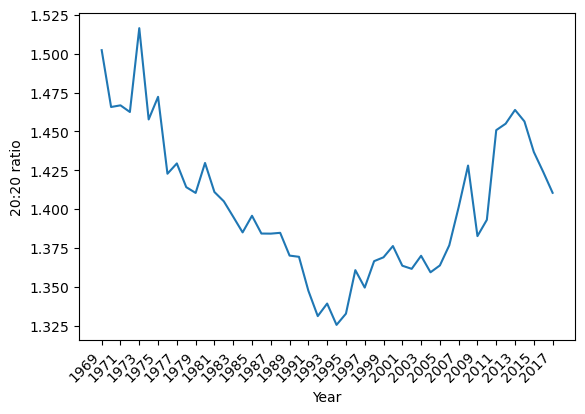

In [12]:
# Generate the range of strings from 1969 to 2018 to grab column names
years = np.arange(1969, 2018).astype(str)

#compute the 20:20 ration for all years
ratio_2020 = pci_df[years].apply(lambda x: (x.quantile(0.8)) / (x.quantile(0.2)), axis=0)

#plot
ax = plt.plot(years, ratio_2020)

fig = plt.gcf()
plt.xticks(years[::2])
plt.ylabel("20:20 ratio")
plt.xlabel("Year")
fig.autofmt_xdate(rotation=45)

plt.show()


The evolution of the ratio has a U-shaped pattern over time - bottoming out around 1994 after a long decline. Post-1994 inequality between county per capita incomes' rise until 2013, where it takes a downturn after 2013. 

In addition to the 20:20 ratio, we will explore two more traditional measures of inequality: the Gini index and Theil's index. For these we will use the inequality package from Pysal.

In [13]:
from pysal.explore import inequality

#### Gini Index

The gini index is a longstanding measure of inequality based on the notion of cumulative wealth distribution [MM21](https://doi.org/10.1371/journal.pone.0251366). The Gini is closely linked to another popular device called the Lorenz curve. To construct a Lorenz curve, the cumulative share of wealth is plotted against the share of the population that owns that wealth. For example, in an extremely unequal society where a few people own nearly all the wealth, the Lorenze curve increases very slowly at first, then sky-rockets once the wealthiest people are included. 

By contrast - a "perfectly equal" society would have all wealth distributed equally, so when plotted as percent of population vs percent of wealth a line with a slope of 1 is generated. In other words if we were to look at this plot, 50% of the population would hold 50% of the wealth, 90% would hold 90% and so-on. The main idea is that the share of wealth or income is exactally proportional to the share of population that owns that wealth or owns income, which only occurs when everyone has the same income or owns the same amount of wealth. 

Whith these notions in mind, we can define the Gini index as the ration of the area between the line of perfect equality and the Lorenze curve for a given wealth distribution, standardized by the area under the line of perfect equality (which is always 1/2, as it is a line with a slope of 1). This the Gini index is a measure of the gap between a perfectly equal society and the observed society over every level of wealth/income. 

We can also construct the Lorenz curve for 1969 by first computing the share of our population of countries that is below each observation. For that, we generate a cumulative series:


In [14]:
n = len(pci_df)
share_of_pop = np.arange(1, n+1)/n

Then, we consider the cumulative evolution of income. For this, we need to find out the proportion of total income owned by each share of the population (cumsum). Emperically, this can be computed in the following fashion:

$\texttt{CumSum(v, k)} = \sum_{i=1}^k v_i$

In [15]:
# Sort counties by income (accending)
incomes = pci_df["1969"].sort_values()

# Next find the o'all percentage of income accumulated at each datapoint
#    by solving for what share of the whole each county represents
shares = incomes/incomes.sum()

# Finally call the cumulative sum as we procress through all counties in the list
cumulative_share = shares.cumsum()

Now we can plot (Figure 4):

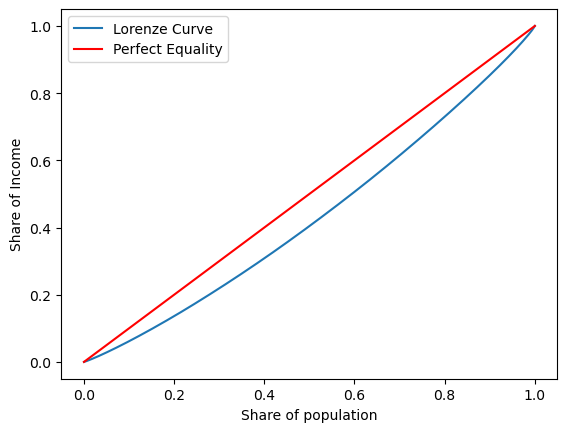

In [16]:
# Generate a figure with one axis
fig, ax  = plt.subplots()

# Plot the Lorenz curve
ax.plot(share_of_pop, cumulative_share, label="Lorenze Curve")

# Plot the line of perfect equality
ax.plot((0,1),(0,1), color="r", label="Perfect Equality")

# Adjust other plot elements
ax.set_xlabel("Share of population")
ax.set_ylabel("Share of Income")
ax.legend()

plt.show()

The blue line is the Lorenz curve for county incomes in 1969. The Gini index is the area between it and the 45-degree line of equality shown in red, all standardized by the area underneath the line of equality.

A first approach to examine how inequality has evolved is to plot the Lorenz curves for each year. One way to do this in Python involves creating a function that will compute the Lorenz curve for an arbitrary set of incomes. The following function encapsulates the steps shown above into a single shot:

In [17]:
def lorenz(y):
    y = np.asarray(y)
    incomes = np.sort(y)
    income_shares = (incomes / incomes.sum()).cumsum()
    N = y.shape[0]
    pop_shares = np.arange(1, N + 1) / N
    return pop_shares, income_shares

In [18]:
lorenz(pci_df["1969"])

(array([3.25097529e-04, 6.50195059e-04, 9.75292588e-04, ...,
        9.99349805e-01, 9.99674902e-01, 1.00000000e+00]),
 array([1.22486441e-04, 2.52956561e-04, 3.83636778e-04, ...,
        9.98429316e-01, 9.99176315e-01, 1.00000000e+00]))

In [19]:
# Generate a curve for each year in our dataset
lorenz_curves = pci_df[years].apply(lorenz, axis=0)

Practically we now have a dataframe with columns for each year. Rows contain the population shares (or income shares) as lists. We can then iterate over the columns (years) of this dataframe, generating a plot of the Lorenz curve for each year (Figure 5).

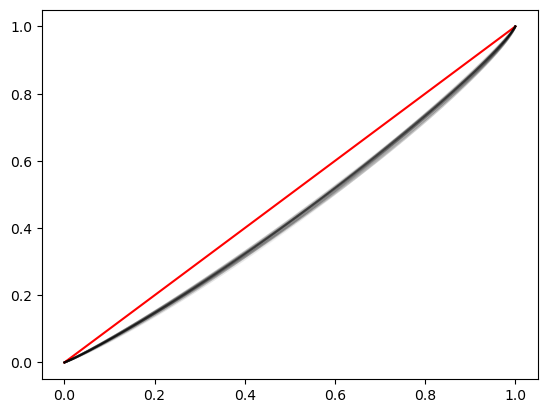

In [20]:
# Set up figure with one axis
f, ax = plt.subplots()
# Plot line of perfect equality
ax.plot((0, 1), (0, 1), color="r")
# Loop over every year in the series
for year in lorenz_curves.columns:
    # Extract the two arrays or each dimension
    year_pop_shares, year_inc_shares = lorenz_curves[year].values
    # Plot Lorenz curve for a given year
    ax.plot(year_pop_shares, year_inc_shares, color="k", alpha=0.05)

The compression fo the Lorenz curve makes it difficult to ascertain the temporal pattern in inequality. Focusing explicitly on the Gini coefficents may shead more light on the
evolution of ineqauality - especially over time. 

Remember, the Gini coefficent represents the area in between the Lorenz curve and that of perfect equality. The measure can be calculated directly through the Gini class in inequality. For 1969 this implies:

In [21]:
g1969 = inequality.gini.Gini(pci_df["1969"].values)

In [22]:
# Extract the coefficent via the g property
g1969.g

0.13556175504269904

inequality’s Gini requires an numpy.ndarray rather than a pandas.Series object, which we can pull out through the values attribute. This is passed to the Gini class, and we only return the value of the coefficient as a DataFrame object.

In [138]:
inequalities = pci_df[years]\
                        .apply(lambda x: inequality.gini.Gini(x).g, axis=0)\
                        .to_frame("gini")

In [139]:
inequalities.head()

,gini
1969,0.135562
1970,0.130076
1971,0.128540
1972,0.129126
1973,0.142166


We can turn this into a graphical represeenation with standard pandas plotting

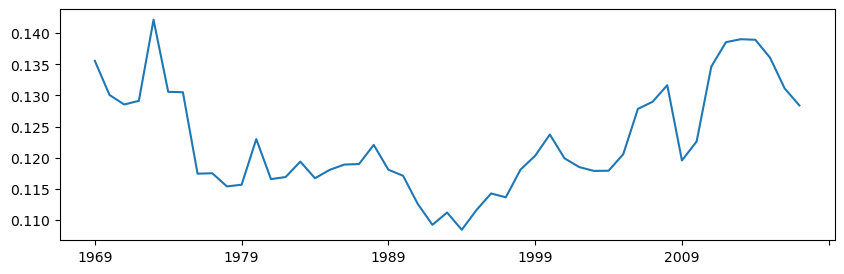

In [140]:
inequalities["gini"].plot(figsize=(10,3));

#### Theil's Index

A third commonly used measure of inequality is Theil's $T$ [MM21](https://doi.org/10.1371/journal.pone.0251366) given as: 

$T = \sum_{i=1}^m \left( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left[ m \frac{y_i}{\sum_{i=1}^m y_i}\right] \right)$

where $y_i$ is per capita income in an area $i$ along $m$ areas. Conceptually, this metric is related to the entropy of the income distribution. Measuring how evenly distributed incomes are across the population. 

The Theil index is also avaliable in Pysal's inequlity, so we can take a similar approach as above to calculate is for every year: 

In [141]:
# NOTE: the nomenclature for the property name is TERRIBLE here: inequality.theil.Theil(x).T

inequalities["theil"] = pci_df[years]\
                        .apply(lambda x: inequality.theil.Theil(x).T, axis=0)\
                        .to_frame("theil")

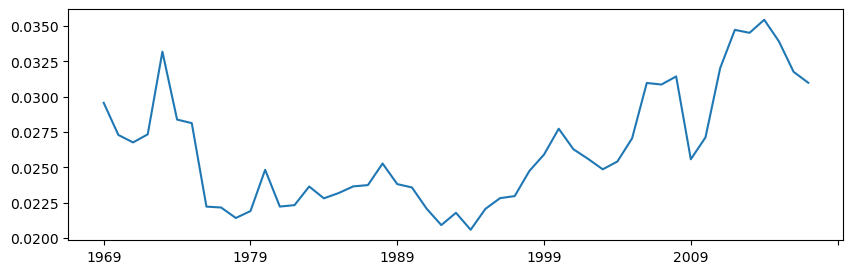

In [142]:
inequalities["theil"].plot(figsize=(10,3));

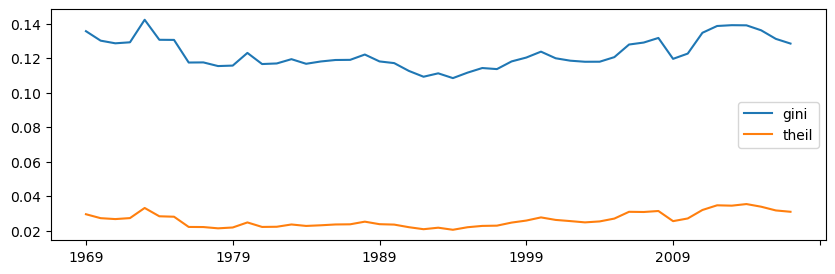

In [143]:
inequalities[["gini","theil"]].plot(figsize=(10,3));

The timeseries of gini and theil coefficents - at first glance - apear to show a striking similarity. However, they are not perfectly correlated, nor substitutes for one another. If plotted against eachother (Figure 8), we can see the disparity in correlation. 

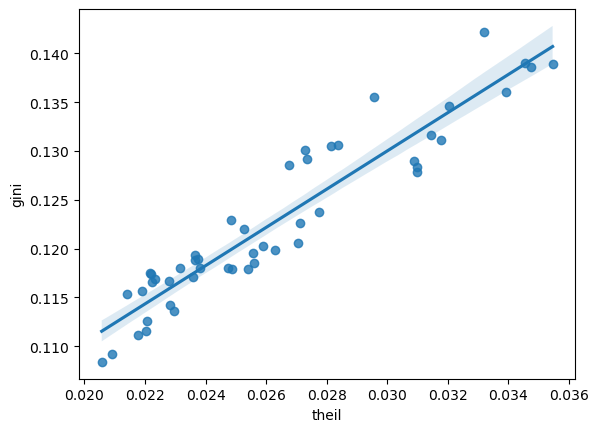

In [144]:
sns.regplot(x="theil", y="gini", data=inequalities);

Indeed, as we shall see below, each index has properties that lend themselves to particular spatial extensions that work in complementary ways. We need both (and more) for a complete picture.


### Personal vs Regional Income

There is a subtle but important distinction between the study of personal and regional income inequality. To see this, we first need to express the relationships between two types of inequality. Consider a country cimprised on $N$ individuals who are distributed over $m$ regions. Let $Y_i$ denote the income of the individual $l$.  Total personal income in a region $i$ is given as $Y_i = \sum_{l \in i} Y_l$, and per capita income in region $i$ is $y_i = \frac{Y_i}{N_i}$, where $N_i$ is the number of individuals in region $i$.

At the national level, the coefficent of variation of incomes could be used as an index of interpersonal income inequality. This would be:

$CV_{nat} = \sqrt{\frac{\sum_{l=1}^N (Y_l - \bar{y})^2}{N}}$

where $\bar{y}$ is the national average for per capita income. The key component here in the sum of squares tern, and inpacking this sheds light on the personal vs regional inequality question:

$TSS = \sum\limits_{i=1}^{N} (Y_l - \bar{y})^2$


An individual deviatio $\delta_l = Y_l - \bar(y)$, is the contribution to inequality associated with an individual $l$. We can break this into two components:

$\delta_l = (Y_l - y_i) +  (y_i - \bar{y})$

The first term is the difference between the individual's income and per capita income in the individual's region of residence, whereas the second term is the difference between the region's per capita income and average national per capita income. 

in regional studies, the intra-regional personal income distribution is typically noat avaliable, As a result the assumption is often made that intra-regional personal inequality is zero. In other words, all individuals in the same region have identical incomes, With this assumption in hand, the first term vanishes $Y_l - y_i = 0$, leading to:<sup>[1]()</sup>

$\begin{split}
\begin{aligned}
TSS &= \sum_{l=1}^N (Y_l - \bar{y})^2 \\
    &= \sum_{l=1}^N \delta_l^2 \\
    &= \sum_{l=1}^N ((Y_l - y_i) +  (y_i - \bar{y}))^2 \\
    &= \sum_{l=1}^N (0 +  (y_i - \bar{y}))^2 \\
    &= \sum_{i=1}^m\sum_{l \in i}  (y_i - \bar{y})^2 \\
    &= \sum_{i=1}^m  [N_i(y_i - \bar{y})]^2
\end{aligned}
\end{split}$

This means that each individual in a region has an equal contribution to the overall level of national interpersonal inequality, given by $(y_i - \bar{y})$, whereas ther region in question contributes $N_i(y_i - \bar{y})$. It may appear that the assumption of zero intra-regional interpersonal inequality is overly restrictive, it ersves to isolate the nature of inter-regional income inequality. Ther is, inequality between places, rather than inequality between people within those places. In essence, this strategy shifts the question up one level in the spatial hierachy by aggregating micro-level individual data to areal units. 



[1] It should also be noted that even at the national scale, the analysis of interpersonal income inequality also relies on aggregate data grouping individuals into income cohorts. See, for example, [PS03](https://doi.org/10.1162/00335530360535135).

### Spatial Inequality

The analysis of regional income inequality differs from the analysis of national interpersonal income inequality in its focus on spatilal units. Since regional incomes are explicitly embedded in geographical space, we can take advantage of their spatial configuration to learn more about the nature of the inequality. In the regional inequality literature this has been approached in a number of ways. Three are considered in this notebook: one that links the discussion to that of spatial autocorrelation (in previous notebooks, both global and local), a second one based on decomposing global indicies regionally, and a third one that embeds space in a traditional global measures. 

#### 1) Spatial autocorrelation - through space and time
This approach helps us shed light on the properties of the spatial pattern of regional income data. We return to the global measures of spatial autocorrelation that we encountered earlier. The essence of this approach is to examine to ewhat extent the spatial distribution of incomes in concentrated over space. For this, we will use the queens spatial weights matrix strategy and calculate Moran's $I$ for each year in the sample:

In [145]:
wq = weights.Queen.from_dataframe(pci_df)

/tmp/ipykernel_4113/2833574135.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = weights.Queen.from_dataframe(pci_df)


Following the same pattern - broadcasting a function - we create a finction that returns the results we need for each statistic. Here, we will also keep the pseudo-$p$-value for the Moran statistic which, as we saw with global spatial autocorrelation, helps us identify whether the inequality index is statistically significant inder the null hypothisis that incomes are randomly distributed geographically. 

In [146]:
# Nested lambda to create variable the outer lambda function can use later
#     This is not the most readable, but is more cinsistent with functional techniques
moran_stats = pci_df[years].apply(lambda y:(          # Calcualted second
                                        lambda mo:    # Calculated first (to avoid redundent calcs)
                                        pd.Series({"I": mo.I, "I-P value": mo.p_sim}))
                                  (esda.Moran(y, w=wq)),
                                  axis=0).T    # Apply over axis 0 (cols), transpose for years as cols    

moran_stats.head()


,I,I-P value
1969,0.649090,0.001
1970,0.647438,0.001
1971,0.626546,0.001
1972,0.606760,0.001
1973,0.640226,0.001


For further comparison, we attach this to the inequalities table we have been plotting:

In [147]:
inequalities = inequalities.join(moran_stats)

and plot (Figure 9)

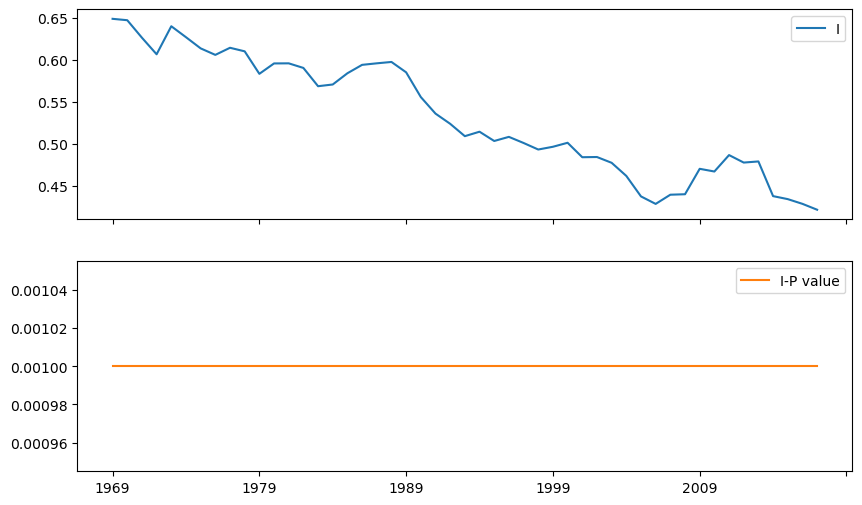

In [148]:
inequalities[["I", "I-P value"]].plot(subplots=True, figsize=(10, 6))
plt.show()

Several patterns emerge from the time series of Morna's $I$. Before exploring the details it is worth noting that, whereas Gini and Theil indicies from previous figures follow a similar path, Moran's $I$ displays a distinct trajectory. There is a long-term decline in the value of Moran's $I$. This suggests a gradual decline in the geographic structure fof inequality with two implications:
* per capita incomes are now less similar between nearby counties
* this has been consistently declining, regardless of whether inequality is high or low

Finally, there has never been a year in which the global spatial autocorrelation has not been statistically significant - in other words, there is a strong geographic structure in the distribution of regional incomes that needs to be accounted for when focusing on inequality questions. 

#### Regional Decomposition of Inequality

One common objection to the analysis of inequality in aggregate relates to the lack of detail about the scale at which inequality is most important. Inequality can be driven by differences between groups and not by discrepancies in income between similar individuals. THat is, there is always the possibility ther observed inequality can be "explained" by a confounding variable, such as age, sex, or education. For example, income differences between older people and younger people can "explain" a large part of the societal inequality in wealth: older people have much longer to aquire experience, and thus are generally paid more for that experience, Younger people do not have as much experience, so young people (on average) have lower incomes than that of older people.

To eackle this issue it is often usefull to *decompose* inequality indicies into constituant groupe. This allows us to inderstand how much of inequality is driven by aggregate group differences and how much is driven by observation-level inequality. This also allows is to characterize how unequal each group is seperatly. In geographic applications, these groups are usually spatially defined, in that *regions* are contigious geographic groups of observations [SW05](http://www.jstor.org/stable/26160606). The following section discusses regional inequality decompositions in a way to introduce geography into the study of inequality. 

Let's illistrate these ideas with our income dataset. The table records the United States Census Bereau region a countybelongs to in the Regions variable. THese divide the couuntry into eieght regions, each assigned a number that relates to its name as specified. 

In [149]:
region_names = {
    1: "New England",
    2: "Mideast",
    3: "Great Lakes",
    4: "Plains",
    5: "Southeast",
    6: "Southwest",
    7: "Rocky Mountain",
    8: "Far West",
}

We can visulize the regions with the names on the legend (Figure 10) by forst mapping the name to each region number, then rendering a qualitative choropleth:

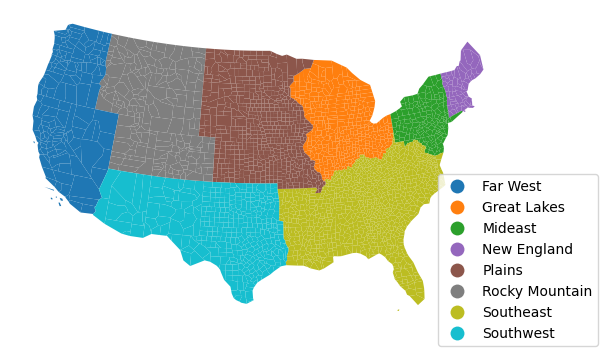

In [150]:
ax = pci_df.assign(Region_Name=pci_df.Region.map(region_names))\
            .plot(
                "Region_Name",
                lw=0,
                legend=True,
                categorical=True,
                legend_kwds={"bbox_to_anchor":(1.2, 0.5)}
             )
ax.set_axis_off();

Let's peak into income changes for eacch region. To do that, we can apply a split-apply-combine pattern that groupe counties by region, calculates the mean across those groupe, then combine the results into a table:

In [151]:
rmeans = pci_df.assign(Region_Name=pci_df.Region.map(region_names))\
                        .groupby(by="Region_Name")[years].mean()

In [152]:
import pandas as pd

# Assuming `pci_df`, `region_names`, and `years` are defined


# Map the Region to Region_Name
pci_df = pci_df.assign(Region_Name=pci_df.Region.map(region_names))

# Group by Region_Name and calculate the mean
rmeans = pci_df.groupby(by="Region_Name")[years].mean()

print(rmeans)


                       1969         1970         1971         1972  \
Region_Name                                                          
Far West        4026.353333  4282.726667  4605.933333  5058.586667   
Great Lakes     3426.800459  3575.077982  3863.880734  4199.541284   
Mideast         3745.112360  4003.943820  4263.578652  4608.359551   
New England     3736.208955  3984.611940  4238.238806  4567.477612   
Plains          3185.181230  3463.689320  3748.909385  4273.289644   
Rocky Mountain  3320.837209  3642.600000  3869.986047  4407.576744   
Southeast       2611.549758  2829.139130  3062.237681  3388.372947   
Southwest       2968.305040  3233.893899  3443.859416  3835.867374   

                       1973         1974         1975         1976  \
Region_Name                                                          
Far West        5621.780000  6265.166667  6749.706667  7185.206667   
Great Lakes     4795.082569  5156.715596  5668.309633  6146.045872   
Mideast         507

The resulting table has a row for each region and a column for each year. We can visulize these means to get as sense of their temporal trajectory (Figure 11)

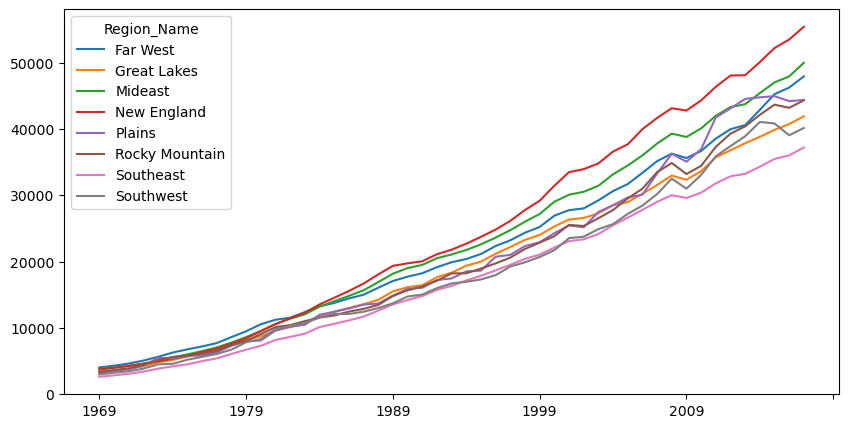

In [153]:
rmeans.T.plot.line(figsize=(10,5));

One way to introduce geography into the analysis of inequality is to use geographical deliniations to define groups for decompositions. For exampls, THerils $T$, which er encountered previously, can be decomposed using regions into so-called *between* and *within* regional inequality components. To proceed in this  direction, we first re-conceptulize our observations of per capita incomes for $m$ regional economies as $y = (y_1, y_2, ..., y_m)$, these are grouped into $\omega$ mutually exclusive regions. Formally, this means that when $m_g$ represents the number of areas assigned to region $g$, the total number of areas must be equal to the count of all the areas in each region: $\sum\limits_{g=1}^{\omega}m_g = m$.<sup>[2]</sup> With this notation, Theil's index from aabove can be rewritten to emphasize its between and within components:

$\begin{split}
\begin{aligned}
T &= \sum\limits_{i=1}^m \left( \frac{y_i}{\sum_{i=1}^mY_i} \ln \left[m\frac{y_i}{\sum_{i=1}^m y_i} \right] \right) \\
  &= \left[\sum\limits_{g=1}^\omega s_g \ln \left( \frac{m}{m_g} s_g \right) \right] + \left[ \sum\limits_{g=1}^\omega s_g \sum\limits_{i \in g} s_{i,g} \ln(m_gs_{i,g})\right] \\
  &= B + W
\end{aligned}
\end{split}$

where $s_g = \frac{\sum_{i \in{g}} y_i}{\sum_{i} y_i}$, and $s_{i,g} = y_i/ \sum_{i\in{g}} y_i$.

The first term is the between regions inequality components, and the second is the within regions inequality component. The within regions term is a weighted average of the inequality between economies belonging to the same region. Similar to what is done above for the case of interpersonal inequality, the estimate of the between-region (group) component of the decomposition is based on setting the incomes of all economies (individuals) belonging to a region (group) equal to that of the regional (group) average of these per capita incomes. Now, however, intera-regional inequality between economies within the samer region is explicitly considered in the same component.<sup>[3]</sup>

Once we have covered the decomposition conceptuallu, the technical implementation is straightforward toanks to the inequality package of Pysal, and the TheilD class:

[2] This would be violated, for example, if one areas were in two regions. Thie area woudl get "double counted" in this total. 

[3] The regional decomposition dies not involve weighting the regions by their respective populaiton. See [Glu18](https://doi.org/10.1080/17421772.2017.1343491) for further details

In [154]:
theil_dr = inequality.theil.TheilD(pci_df[years].values, pci_df.Region)

The theil_dr object has the between and within group components stored in the bg and wg attributes respecrivly. For example, the "between" component for each year is computed as: 

In [155]:
theil_dr.bg

array([0.00914353, 0.00822696, 0.00782675, 0.00768201, 0.01022634,
       0.0081274 , 0.00783943, 0.00572543, 0.00560271, 0.0054971 ,
       0.00511791, 0.00566001, 0.00486877, 0.00466134, 0.00474425,
       0.00424528, 0.00428434, 0.00453503, 0.00465829, 0.00456699,
       0.00467363, 0.00412391, 0.00366334, 0.00342112, 0.00327131,
       0.00312475, 0.00326071, 0.00359733, 0.00327591, 0.00363014,
       0.00382409, 0.00436261, 0.00399156, 0.00402506, 0.00397   ,
       0.00394649, 0.00353368, 0.00362698, 0.00400508, 0.00449814,
       0.0043533 , 0.00470988, 0.0063954 , 0.00642426, 0.00694236,
       0.00644971, 0.00591871, 0.00554072, 0.00528702])

If we store these decompositions in our results table as we have been doing:

In [156]:
inequalities["theil_between"] = theil_dr.bg
inequalities["theil_within"] = theil_dr.wg

Inference on these decompositions can be done using the inequality.theil.TheilDSim class, we calculate that and explore below, using the observations for each year (*y*) and the regions that contain counties (partition). 

for each year we get a p-alus and an array woth the observed statistic and each simulation (random shuffle; Figure 12)



In [162]:

# Nested lambda to create variable the outer lambda function can use later
#     This is not the most readable, but is more cinsistent with functional techniques

theil_stats = pci_df[years].apply(lambda y:(          # Calcualted second
                                        lambda th:    # Calculated first (to avoid redundent calcs)
                                        pd.Series({"BG": th.bg, "BG-P value": th.bg_pvalue}))
                                  (inequality.theil.TheilDSim(y, partition=pci_df.Region.values, permutations=99)),
                                  axis=0).T    # Apply over axis 0 (cols), transpose for years as cols    

theil_stats.head()

#bg is anarray with n+1 permutations, where the 0th index is the data as is and rthe rest are the following permutations



,BG,BG-P value
1969,"[[0.009143527184973601], [1.4233493846491042e-...",[0.01]
1970,"[[0.008226962623048131], [4.813116511281782e-0...",[0.01]
1971,"[[0.007826753198293478], [2.93051495942584e-05...",[0.01]
1972,"[[0.007682010662640397], [0.000110398687853742...",[0.01]
1973,"[[0.010226335517764334], [7.801453634505512e-0...",[0.01]


In [163]:
inequalities = inequalities.join(theil_stats)

ValueError: columns overlap but no suffix specified: Index(['BG', 'BG-P value'], dtype='object')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert columns to numpy arrays
BG_values = np.array(inequalities['BG'].tolist())
BG_P_values = inequalities['BG-P value']

# Create a figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot each BG value series in the first subplot, starting from the second series
for i in range(0, BG_values.shape[1]):
    axes[0].plot(inequalities.index, BG_values[:, i])
    # Annotate the last point of each series
    axes[0].annotate(f'Series {i+1}', xy=(inequalities.index[-1], BG_values[-1, i]), 
                     xytext=(5, 0), textcoords='offset points', fontsize=8)

# Add labels and title to the first subplot
axes[0].set_title('BG Values')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Value')

# Plot BG-P value in the second subplot
axes[1].plot(inequalities.index, BG_P_values, label='BG-P value', color='red')

# Add labels and title to the second subplot
axes[1].set_title('BG-P Value')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')
axes[1].legend(loc='best')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


All of the Theil decompositions are statistically significant.

Since the within and between components are interpreted as shares of the overall Theil index, we can compute the share of the Theil index due to the between-region inequality.

In [165]:
inequalities["theil_between_share"] = inequalities["theil_between"]/inequalities["theil"]

We can visulize the results (Figure 13):

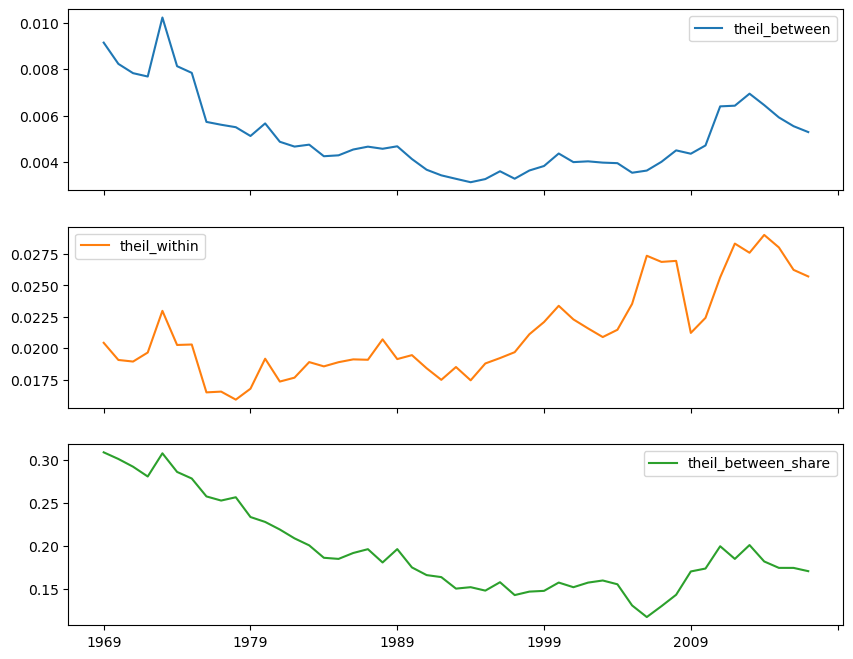

In [167]:
inequalities[
                ["theil_between","theil_within", "theil_between_share"]
            ].plot(subplots=True, figsize=(10,8));

The between-region share of inequality is at its lowest in the mod-2000s, not the mid-1990s. This suggests that regional differences were very important drivers of inequalityin the 1970s and 1980s, but this importance has been waning, relative to the inequality *within* the U.S. Census Regions. The ratio attributed to between region differences also generally exhibits the same pattern (decreasing until the early/mid 2000s), but does not see the minima in the same places. 